### Modelagem dos dados

#### Problema de negócio:

##### - Houve aumento no número de clientes que abandonaram o serviço de cartão de crédito do banco. Como reduzir os potenciais Churns ? 

#### Objetivo:

##### - Construir um modelo para identificar os clientes mais propensos a serem Churn no futuro


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV



from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier
from xgboost import XGBClassifier


from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, SelectFromModel, chi2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import LinearSVC

# Avaliação do modelo
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.calibration import calibration_curve



### Importando os dados

In [2]:
dados = pd.read_csv('C:\\Users\\Caio\\Desktop\\Credit Card Customers\\Dados\\BankChurners.csv')

In [3]:
dados.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
dados['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [5]:
dados['Attrition_Flag'].replace('Existing Customer', 0, inplace=True)
dados['Attrition_Flag'].replace('Attrited Customer', 1, inplace=True)


features = dados.drop(['Attrition_Flag', 'CLIENTNUM',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis = 1)

target = dados['Attrition_Flag']

#### Split treino/teste

In [6]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size= 0.2,stratify= target, random_state= 101)



In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8101, 19)
(8101,)
(2026, 19)
(2026,)


In [6]:
# a mesma proporção de churn tanto no treino como no teste


print(y_train.value_counts(1))

print(y_test.value_counts(1))

0    0.839279
1    0.160721
Name: Attrition_Flag, dtype: float64
0    0.839585
1    0.160415
Name: Attrition_Flag, dtype: float64


#### Pre Processing

In [7]:
# separando as variáveis categóricas das numéricas

col_categorico = [i for i in x_train.columns if x_train[i].dtype.name == 'object']

col_numerica = [i for i in x_train.columns if i not in col_categorico]

##### Classes desbalanceadas e por isso vamos estimar o peso das classes utilizando compute_class_weight

In [8]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

dict(zip(np.unique(y_train), class_weights))

{0: 0.5957493749080747, 1: 3.1109831029185866}

### Pipelines

##### Vamos testar vários modelos. Por isso irei criar um pipeline para cada "algoritmo" a ser testado

In [9]:
 
# Transformações OneHotEncoder nas variáveis categóricas


categorico = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown= 'ignore'), col_categorico),
], remainder = 'passthrough')


# Pipeline XGBoost

pipeline_xgb = Pipeline([
    ('cat', categorico),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif)),
    ('XGBoost', XGBClassifier(class_weights = {0:class_weights[0], 1:class_weights[1]}, random_state = 42))
])


# Pipeline Random Forest

pipeline_rf = Pipeline([
    ('cat', categorico),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif)),# feature selection
    ('randomForest',RandomForestClassifier(class_weight = {0:class_weights[0], 1:class_weights[1]},random_state = 42))])


# Pipeline Decision Tree

pipeline_tree = Pipeline([
    ('cat',categorico),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif)),
    ('tree',DecisionTreeClassifier(class_weight= {0:class_weights[0], 1:class_weights[1]}, random_state=42))])



# Pipeline Logistic Regression


# pre processamento aplicado aos dados de logistic regression. Nesse caso aplicamos normalização
pre_processamento = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), col_categorico),
    ('scaler', StandardScaler(), col_numerica)
])


pipeline_log_reg = Pipeline([
    ('preprocessamento',pre_processamento),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif)),
    ('logReg',LogisticRegression(class_weight={0:class_weights[0], 1:class_weights[1]}, random_state=42))])




In [10]:
# Treinando os três modelos ao mesmo tempo

algoritmos = [pipeline_xgb,pipeline_rf, pipeline_log_reg, pipeline_tree]


for modelo in algoritmos:
    modelo.fit(x_train, y_train)

c:\Users\Caio\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [10:51:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weights" } are not used.

  warnings.warn(smsg, UserWarning)


### Cross Validation

In [11]:
# Cross Validation com 5 folds

val_cruzada = KFold(n_splits = 5, shuffle = True, random_state = 53)

In [12]:
# métricas a ser computada com o cross validation

metrics = ['recall', 'precision','accuracy', 'f1']


# Cross Validate com XGBoost


cross_validatexgb = cross_validate(pipeline_xgb, x_train, y_train, cv = val_cruzada, scoring = metrics)


recall_xgb = cross_validatexgb['test_recall'].mean()
precision_xgb = cross_validatexgb['test_precision'].mean()
accuracy_xgb = cross_validatexgb['test_accuracy'].mean()
f1_xgb = cross_validatexgb['test_f1'].mean()



# Cross Validate com Random Forest


cross_validaterf = cross_validate(pipeline_rf, x_train, y_train, cv = val_cruzada, scoring = metrics)


recall_rf = cross_validaterf['test_recall'].mean()
precision_rf = cross_validaterf['test_precision'].mean()
accuracy_rf = cross_validaterf['test_accuracy'].mean()
f1_rf = cross_validaterf['test_f1'].mean()



# Cross Validate com Logistic Regression

cross_validate_logReg = cross_validate(pipeline_log_reg, x_train, y_train, cv = val_cruzada, scoring = metrics)

recall_logReg = cross_validate_logReg['test_recall'].mean()
precision_logReg = cross_validate_logReg['test_precision'].mean()
accuracy_logReg = cross_validate_logReg['test_accuracy'].mean()
f1_logReg = cross_validate_logReg['test_f1'].mean()



# Cross Validate com Decision Tree


cross_validate_tree = cross_validate(pipeline_tree, x_train, y_train, cv = val_cruzada, scoring = metrics)


recall_tree = cross_validate_tree['test_recall'].mean()
precision_tree = cross_validate_tree['test_precision'].mean()
accuracy_tree = cross_validate_tree['test_accuracy'].mean()
f1_tree = cross_validate_tree['test_f1'].mean()

c:\Users\Caio\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [10:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weights" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Caio\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [10:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weights" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Caio\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [10:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weights" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Caio\anaconda3\lib\site-packages\xgboost\core.py:

### Comparativo entre os modelos

In [13]:
print("Comparativo entre os Modelos:")
print("_____________________________")

print("\n")


print("XGBoost Metrics Cross Validation:")
print(" Accuracy Mean: {}".format(accuracy_xgb))
print(" Precision Mean: {}".format(precision_xgb))
print(" Recall Mean: {}".format(recall_xgb))
print(" F1 Mean: {}".format(f1_xgb))




print("\n")

print("Random Forest Metrics Cross Validation:")
print(" Accuracy Mean: {}".format(accuracy_rf))
print(" Precision Mean: {}".format(precision_rf))
print(" Recall Mean: {}".format(recall_rf))
print(" F1 Mean: {}".format(f1_rf))


print("\n")

print("Logistic Regression Metrics Cross Validation:")


print(" Accuracy Mean: {}".format(accuracy_logReg))
print(" Precision Mean: {}".format(precision_logReg))
print(" Recall  Mean: {}".format(recall_logReg))
print(" F1 Mean: {}".format(f1_logReg))

print("\n")

print("Decision Tree Metrics Cross Validation:")


print(" Accuracy Mean: {}".format(accuracy_tree))
print(" Precision Mean: {}".format(precision_tree))
print(" Recall Mean: {}".format(recall_tree))
print(" F1 Mean: {}".format(f1_tree))

Comparativo entre os Modelos:
_____________________________


XGBoost Metrics Cross Validation:
 Accuracy Mean: 0.9635843596012215
 Precision Mean: 0.9019058891994604
 Recall Mean: 0.8689246847789274
 F1 Mean: 0.885041203946533


Random Forest Metrics Cross Validation:
 Accuracy Mean: 0.9540794814967135
 Precision Mean: 0.9044632408061062
 Recall Mean: 0.8006629474033671
 F1 Mean: 0.8492899163267346


Logistic Regression Metrics Cross Validation:
 Accuracy Mean: 0.8363154888386226
 Precision Mean: 0.4948968870416219
 Recall  Mean: 0.8503231183101164
 F1 Mean: 0.6255430711772719


Decision Tree Metrics Cross Validation:
 Accuracy Mean: 0.9271689476850901
 Precision Mean: 0.7859923980370735
 Recall Mean: 0.7537853070996319
 F1 Mean: 0.769437320119437


### Iremos selecionar o Random Forest pois aparenta ser o mais promissor para esse problema específico

#### Tunando somente um hiperparametro e selecionando as melhores features com base no teste F

In [14]:
# alternativo

params = {'feature_selection__k': [10,11,12],
          'randomForest__n_estimators': [10, 20, 30],
          'randomForest__min_samples_split': [4,6,10],  # usar 2 (DOIS) __
          'randomForest__max_depth': [10,20,30]}
          

rf_grid = GridSearchCV(estimator= pipeline_rf, 
                      param_grid= params, 
                      scoring = 'accuracy',
                      cv = 3,
                      n_jobs= -1)

In [15]:
rf_grid.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cat',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'Education_Level',
                                                                          'Marital_Status',
                                                                          'Income_Category',
                                                                          'Card_Category'])])),
                                       ('feature_selection',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x000002448B5C1820>)),
                                       ('randomForest',
                                        RandomForestClassifier(class_weight={0: 0.5957493749080747,
                                                                             1: 3.1109831029185866},
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [10, 11, 12],
                         'randomForest__max_depth': [10, 20, 30],
                         'randomForest__min_samples_split': [4, 6, 10],
                         'randomForest__n_estimators': [10, 20, 30]},
             scoring='accuracy')

In [16]:
print(rf_grid.score(x_train, y_train))

0.9881496111591161


#### Agora que já selecionamos o modelo, tunamos os hiperparametros e avaliamos algumas métricas podemos ir a base de teste

In [17]:
y_pred = rf_grid.predict(x_test)

#### Métricas do nosso modelo com a base de teste

In [18]:
print("Precision Score: {}".format(precision_score(y_test, y_pred)))
print("Recall Score: {}".format(recall_score(y_test, y_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_pred)))
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))


Precision Score: 0.8523076923076923
Recall Score: 0.8523076923076923
F1 Score: 0.8523076923076923
Accuracy Score: 0.9526159921026653


In [19]:
print(confusion_matrix(y_test,y_pred))

[[1653   48]
 [  48  277]]


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1701
           1       0.85      0.85      0.85       325

    accuracy                           0.95      2026
   macro avg       0.91      0.91      0.91      2026
weighted avg       0.95      0.95      0.95      2026



#### Curva ROC

In [21]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

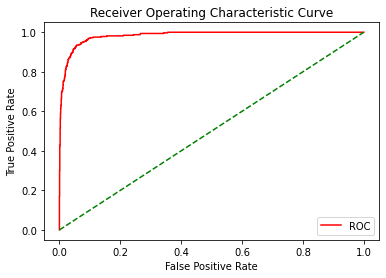

In [22]:
prob = rf_grid.predict_proba(x_test)

prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)

In [23]:
print("ROC AUC SCORE: {}".format(roc_auc_score(y_test, prob)))

ROC AUC SCORE: 0.9831357120246009


In [24]:
y_scores = rf_grid.predict_proba(x_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

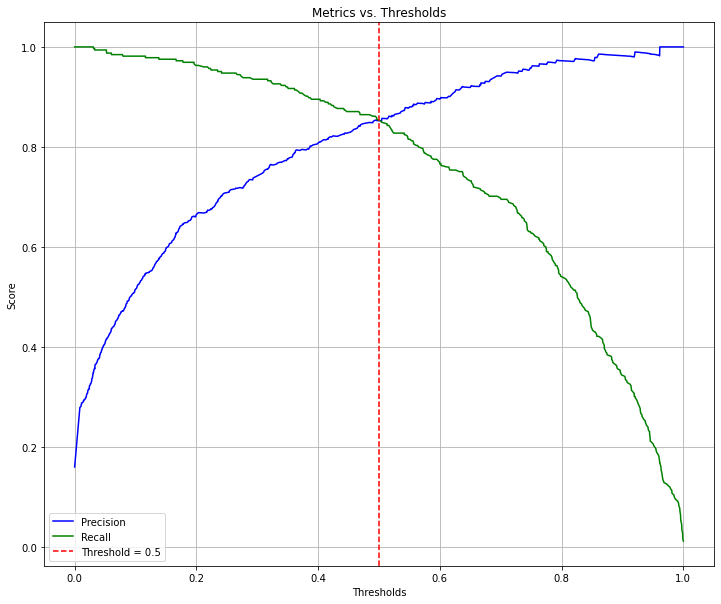

In [25]:
plt.figure(figsize=(12, 10))
plt.plot(thresholds, precision[:-1], color='Blue', label='Precision')
plt.plot(thresholds, recall[:-1], color='Green', label='Recall')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.title('Metrics vs. Thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
probabilidades = rf_grid.predict_proba(x_test)

classe_predita = (probabilidades[:, 1] >= 0.4).astype(int)

In [27]:
print(classification_report(y_test, classe_predita))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1701
           1       0.81      0.90      0.85       325

    accuracy                           0.95      2026
   macro avg       0.89      0.93      0.91      2026
weighted avg       0.95      0.95      0.95      2026



#### Calibration Curves - O quão calibrado estão as previsões do nosso modelo ?

Text(0, 0.5, 'True Probability')

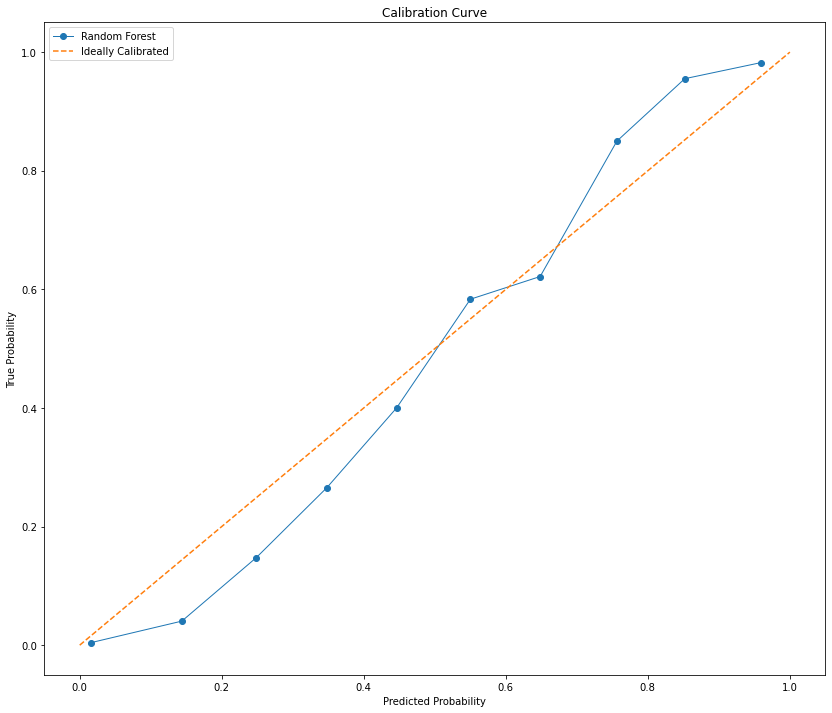

In [37]:
true_pos, pred_pos = calibration_curve(y_test, y_scores, n_bins = 10)



plt.subplots(figsize = (14,12))
plt.plot(pred_pos, true_pos, marker = 'o', linewidth = 1, label = 'Random Forest')

plt.plot([0,1], [0,1], linestyle = '--', label = "Ideally Calibrated")
plt.legend()
plt.title('Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')

##### Dificilmente um banco irá utilizar um modelo como saída binária 0 e 1. Faz sentido criarmos uma faixa "Risco de Churn" com base nos scores preditos pelo modelo. Isso permitirá o banco adotar diferentes planos de ação com base no risco de cada cliente. 

##### Um cliente com alto risco de churn necessitará de uma abordagem cirúrgia e comercialmente agressiva, diferentemente de um cliente que possui risco baixo de churn. Essa segmentação facilitará tornará mais efetiva a atuação do banco na mitigação de churn

In [38]:
df_risco = x_test.copy()

df_risco['Probabilidade_Churn'] = probabilidades[:,1]

df_risco['Real_Target'] = y_test



# Criando score 'Risco de Churn'

intervalos = [0.0000, 0.20,0.40,0.60,0.80,0.9999]

rotulos = ['Zero', 'Baixo', 'Médio', 'Alto', 'Altíssimo']

df_risco['Risco_Churn'] = pd.cut(df_risco['Probabilidade_Churn'], bins=intervalos, labels=rotulos, include_lowest=True)


##### Vamos cruzar o score criado com as probabilidades previstas pelo modelo, com o Target real dos nossos dados de teste. 

##### Quanto que o nosso modelo está acertando ? Podemos verificar que há erros em todos os cenários(scores), porém a segmentação dos clientes nessas faixas(score) facilita o plano estratégico do Banco. 


In [39]:

pivot_df = df_risco.pivot_table(index='Risco_Churn', columns='Real_Target', aggfunc='size', fill_value=0)

pivot_df.columns = ['No Churn', 'Churn']

print(pivot_df)

             No Churn  Churn
Risco_Churn                 
Zero             1544     12
Baixo              88     22
Médio              41     42
Alto               23     74
Altíssimo           5    171


In [42]:
df_risco.tail()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Probabilidade_Churn,Real_Target,Risco_Churn
1717,63,F,2,Graduate,Married,$40K - $60K,Blue,53,4,2,...,1874,1193.0,0.791,1420,32,0.455,0.611,0.054306,0,Zero
9493,50,F,4,Graduate,Single,Less than $40K,Blue,37,1,2,...,913,2786.0,0.866,7297,71,0.690,0.247,0.409118,1,Médio
9752,47,M,3,Graduate,Single,$40K - $60K,Blue,34,4,3,...,232,4181.0,0.799,7869,76,0.767,0.053,0.818011,1,Altíssimo
3669,50,M,1,Uneducated,Married,$60K - $80K,Blue,40,6,1,...,996,3096.0,0.644,2298,48,0.655,0.243,0.226254,0,Baixo
1650,62,F,2,Graduate,Married,Less than $40K,Blue,51,6,2,...,1632,1354.0,0.883,2141,55,0.667,0.547,0.111995,0,Zero


### Abrindo a caixa preta: como podemos entender esse modelo ?

##### Quais são as variáveis mais importantes para o nosso modelo ? 

Text(0, 0.5, '')

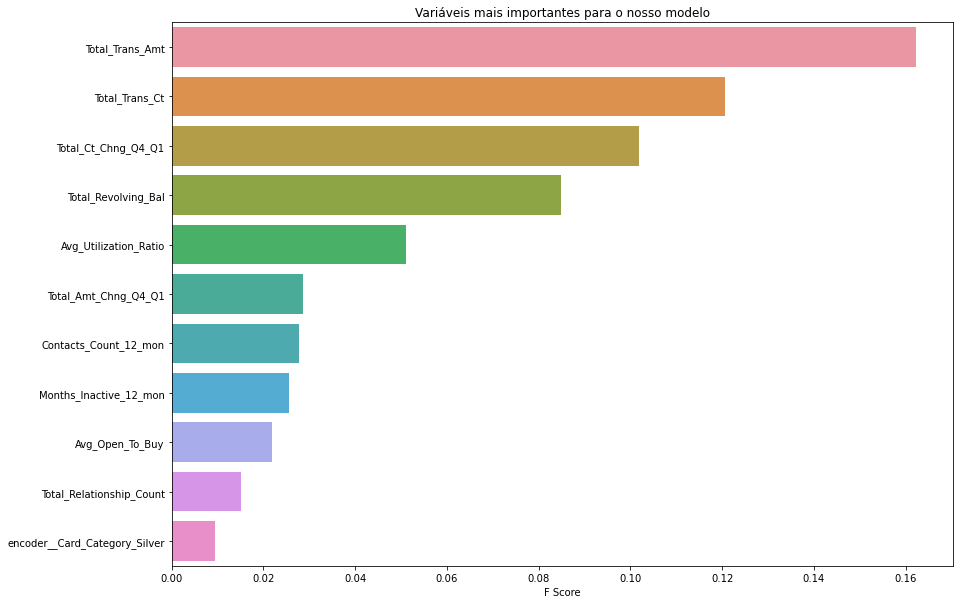

In [35]:
scores_variaveis = rf_grid.best_estimator_.named_steps['feature_selection'].scores_

variaveis_selecionadas = rf_grid.best_estimator_.named_steps['feature_selection'].get_support()

#x_train_trans = categorico.transform(x_train)

#all_features = x_train.columns

variaveis = categorico.get_feature_names_out()



df = pd.DataFrame(data = variaveis[variaveis_selecionadas])

df['Score'] = scores_variaveis[variaveis_selecionadas].tolist()

df = df.rename(columns={0:"Variables"})


df['Variables'] = df['Variables'].str.replace(r'remainder__','', regex = True)


df = df.sort_values("Score", ascending=False)


plt.subplots(figsize = (14,10))

sns.barplot(data = df, x = "Score", y = "Variables")

plt.title("Variáveis mais importantes para o nosso modelo")
plt.xlabel("F Score")
plt.ylabel("")

#### Como é a relação de dependencia entre nossa variável resposta e as variáveis preditoras do nosso modelo ?

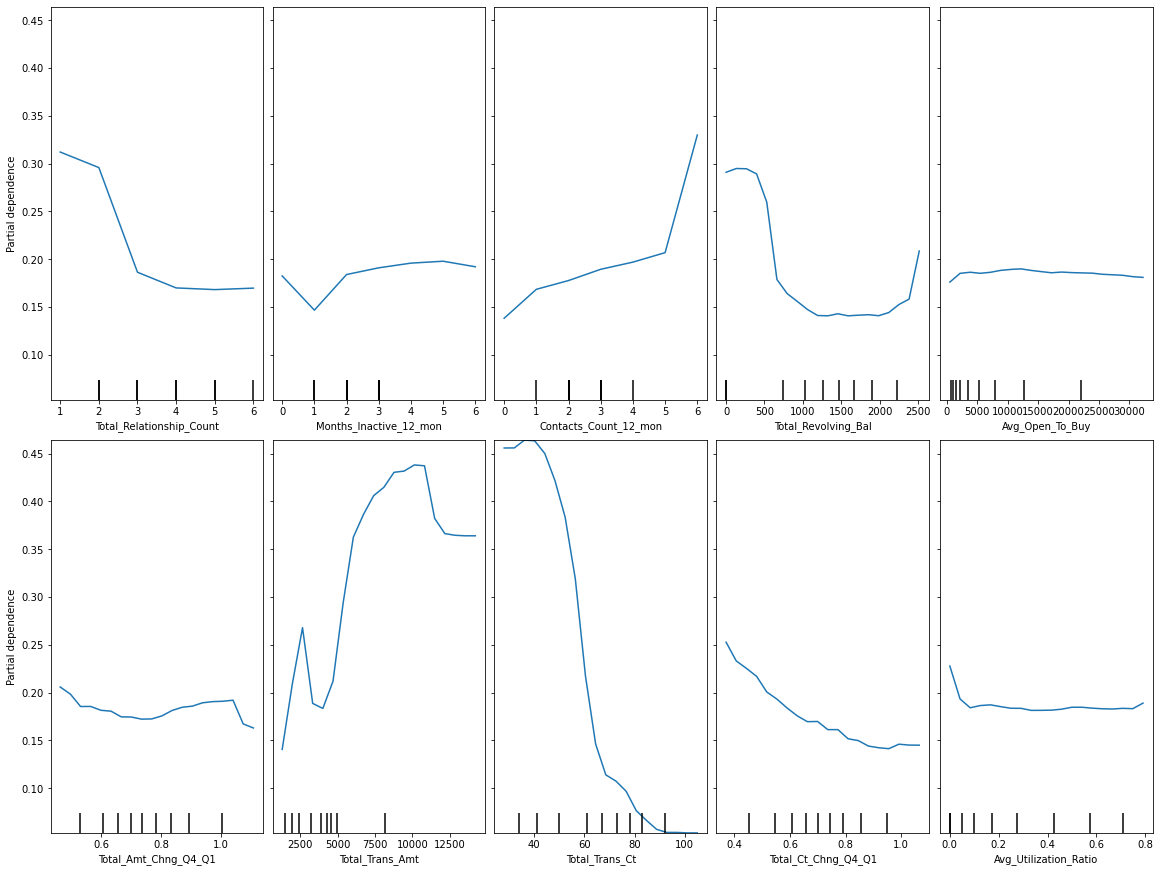

In [36]:
# Partial Dependencia Plot

from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": -1,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    "features":["Total_Relationship_Count",
                "Months_Inactive_12_mon",
                "Contacts_Count_12_mon",
                "Total_Revolving_Bal",
                "Avg_Open_To_Buy",
                "Total_Amt_Chng_Q4_Q1",
                "Total_Trans_Amt",
                "Total_Trans_Ct",
                "Total_Ct_Chng_Q4_Q1",
                "Avg_Utilization_Ratio"],
    "kind":"average"
}


_, ax = plt.subplots(ncols=5, nrows=2, figsize=(16, 12), constrained_layout=True)


display = PartialDependenceDisplay.from_estimator(
    rf_grid, 
    x_train,
    **features_info,
    ax = ax,
    **common_params


)

In [61]:
# Exportando o nosso modelo de classificação

model_churn = "model_churn.pkl"  

with open(model_churn, 'wb') as file:  
    pickle.dump(rf_grid, file)